<img style="float: left;" src="books.png">

# Algorithmic Book Recommendations at Sehir Library
#### CS 340 Spring 2017-18

### Outline
1. Dataset
2. Exploratory Data Analysis (EDA)
2. Interactive EDA
3. Collaborative Filtering
4. Some insights
5. Recommending Books
6. Final Comments

In [1]:
import findspark
findspark.init()
import pyspark

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use("seaborn")
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize']= plt.figaspect(0.4)

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("CS340 Term Project")\
    .getOrCreate()
    
df_users = spark.read.csv("data_csv_users.csv", header= True, encoding="UTF-8")
df_books = spark.read.csv("data_csv_books.csv", header= True, encoding = "UTF-8", multiLine=True)

# 1. Dataset

The data for the project comes from the Şehir Library databases and includes the following tables. 
1. A table containing non-timestamped history of borrowing for users.
2. A table containing identifying information (ID number, Library of Congress markers etc).

![title](data.png)

# 2. Exploratory Data Analysis (EDA)

## 2.1 EDA - Library Users

In [4]:
df_users.columns

['User_ID', 'Books_ID']

In [6]:
df_users.show(5)

+-------+------------+
|User_ID|    Books_ID|
+-------+------------+
|      z|000101688001|
|      z|000101688001|
|      z|000104574001|
|      z|000104574001|
|      z|000104842001|
+-------+------------+
only showing top 5 rows



In [7]:
df_users.printSchema()

root
 |-- User_ID: string (nullable = true)
 |-- Books_ID: string (nullable = true)



In [8]:
from pyspark.sql.functions import countDistinct, count, min,max
df_users_count = df_users.select(countDistinct('User_ID'), countDistinct('Books_ID'))

In [9]:
df_users_count.show()

+-----------------------+------------------------+
|count(DISTINCT User_ID)|count(DISTINCT Books_ID)|
+-----------------------+------------------------+
|                   2111|                    5574|
+-----------------------+------------------------+



In [10]:
df_users_count_pd = df_users_count.toPandas()

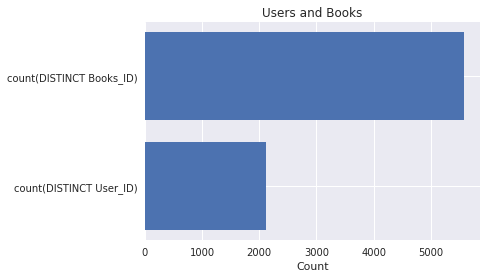

In [11]:
plt.figure()
plt.barh(range(df_users_count_pd.shape[1]), df_users_count_pd.values.flatten())
plt.xlabel("Count")
plt.title("Users and Books")
plt.yticks(list(range(df_users_count_pd.shape[1])), df_users_count_pd.columns)
plt.show()

In [12]:
df_borrow_count = df_users.groupby('User_ID').agg(countDistinct('Books_ID').alias('borrow_count_by_user'))\
.orderBy('borrow_count_by_user',ascending =False)

In [13]:
df_borrow_count.show(5)

+-------+--------------------+
|User_ID|borrow_count_by_user|
+-------+--------------------+
|     mf|                 336|
|     zl|                 213|
|    akz|                 209|
|    zmz|                 174|
|     my|                  79|
+-------+--------------------+
only showing top 5 rows



In [14]:
df_borrow_count_pd = df_borrow_count.toPandas()

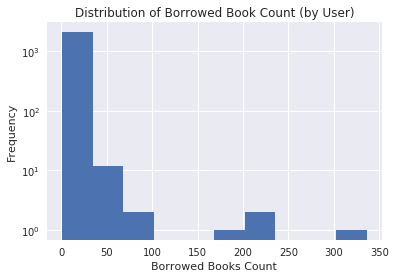

In [15]:
plt.figure()
plt.hist(df_borrow_count_pd.borrow_count_by_user, log=True)
plt.xlabel("Borrowed Books Count")
plt.ylabel("Frequency")
plt.title("Distribution of Borrowed Book Count (by User)")
plt.show()

## 2.2 EDA - Books

In [16]:
df_books.columns

['ID', 'CLASS', 'TITLE', 'SUBJECTS\r']

In [17]:
df_books = df_books.withColumnRenamed("SUBJECTS\r", "SUBJECTS")

In [18]:
df_books.printSchema()

root
 |-- ID: string (nullable = true)
 |-- CLASS: string (nullable = true)
 |-- TITLE: string (nullable = true)
 |-- SUBJECTS: string (nullable = true)



In [19]:
df_books.show(5)

+------------+-----------------+--------------------+--------------------+
|          ID|            CLASS|               TITLE|            SUBJECTS|
+------------+-----------------+--------------------+--------------------+
|000004169001|N 5300 .G6419/S26|Sanat?n �yk�s� = ...|Art--History
Sana...|
|000007392001| PK 6418 .H35/M84|Mughal poetry : i...|Persian Poetry--M...|
|000007458001| PT 2653 .W42/K67|  Korku ruhu kemirir|German Literature...|
|000021617001|QC 171.2 .D36/E68|Equations of eter...|Matter--Mathemati...|
|000022954001|    QH 11 .D2/V69|The voyage of the...|Natural History
G...|
+------------+-----------------+--------------------+--------------------+
only showing top 5 rows



In [20]:
from pyspark.sql.functions import udf
udfBookSubject = spark.udf.register("extractBookSubject", lambda x: x.strip().split(" ")[0])

In [21]:
df_books = df_books.withColumn("CLASS_SUBJECT", udfBookSubject("CLASS"))

In [22]:
df_books.show(5)

+------------+-----------------+--------------------+--------------------+-------------+
|          ID|            CLASS|               TITLE|            SUBJECTS|CLASS_SUBJECT|
+------------+-----------------+--------------------+--------------------+-------------+
|000004169001|N 5300 .G6419/S26|Sanat?n �yk�s� = ...|Art--History
Sana...|            N|
|000007392001| PK 6418 .H35/M84|Mughal poetry : i...|Persian Poetry--M...|           PK|
|000007458001| PT 2653 .W42/K67|  Korku ruhu kemirir|German Literature...|           PT|
|000021617001|QC 171.2 .D36/E68|Equations of eter...|Matter--Mathemati...|           QC|
|000022954001|    QH 11 .D2/V69|The voyage of the...|Natural History
G...|           QH|
+------------+-----------------+--------------------+--------------------+-------------+
only showing top 5 rows



In [23]:
df_books_count = df_books.select(countDistinct('ID'), countDistinct('CLASS_SUBJECT'))

In [24]:
df_books_count.show()

+------------------+-----------------------------+
|count(DISTINCT ID)|count(DISTINCT CLASS_SUBJECT)|
+------------------+-----------------------------+
|              6094|                          171|
+------------------+-----------------------------+



In [24]:
df_books_count_pd = df_books_count.toPandas()

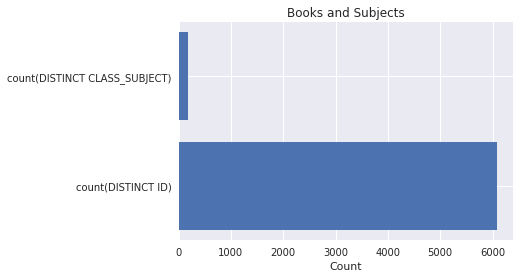

In [25]:
plt.figure()
plt.barh(range(df_books_count_pd.shape[1]), df_books_count_pd.values.flatten())
plt.xlabel("Count")
plt.title("Books and Subjects")
plt.yticks(list(range(df_books_count_pd.shape[1])), df_books_count_pd.columns)
plt.show()

## 2.3 EDA - Users and Books

In [26]:
df_merged = df_users.join(df_books, df_users.Books_ID == df_books.ID, "inner")

In [27]:
df_merged.columns

['User_ID', 'Books_ID', 'ID', 'CLASS', 'TITLE', 'SUBJECTS', 'CLASS_SUBJECT']

In [28]:
df_merged.printSchema()

root
 |-- User_ID: string (nullable = true)
 |-- Books_ID: string (nullable = true)
 |-- ID: string (nullable = true)
 |-- CLASS: string (nullable = true)
 |-- TITLE: string (nullable = true)
 |-- SUBJECTS: string (nullable = true)
 |-- CLASS_SUBJECT: string (nullable = true)



In [29]:
df_merged.show(5)

+---------+------------+------------+-----------------+--------------------+--------------------+-------------+
|  User_ID|    Books_ID|          ID|            CLASS|               TITLE|            SUBJECTS|CLASS_SUBJECT|
+---------+------------+------------+-----------------+--------------------+--------------------+-------------+
|pzkzczrly|000004169001|000004169001|N 5300 .G6419/S26|Sanat?n �yk�s� = ...|Art--History
Sana...|            N|
|kzlcpzfll|000004169001|000004169001|N 5300 .G6419/S26|Sanat?n �yk�s� = ...|Art--History
Sana...|            N|
|mzplkmfll|000004169001|000004169001|N 5300 .G6419/S26|Sanat?n �yk�s� = ...|Art--History
Sana...|            N|
|mzlmacrzl|000004169001|000004169001|N 5300 .G6419/S26|Sanat?n �yk�s� = ...|Art--History
Sana...|            N|
|mzlmacrzl|000004169001|000004169001|N 5300 .G6419/S26|Sanat?n �yk�s� = ...|Art--History
Sana...|            N|
+---------+------------+------------+-----------------+--------------------+--------------------+-------

In [30]:
df_merged_count = df_merged.select(countDistinct('User_ID'), countDistinct('Books_ID'), countDistinct("CLASS_SUBJECT"))

In [31]:
df_merged_count.show()

+-----------------------+------------------------+-----------------------------+
|count(DISTINCT User_ID)|count(DISTINCT Books_ID)|count(DISTINCT CLASS_SUBJECT)|
+-----------------------+------------------------+-----------------------------+
|                   2111|                    5574|                          169|
+-----------------------+------------------------+-----------------------------+



In [32]:
df_merged_count_pd = df_merged_count.toPandas()

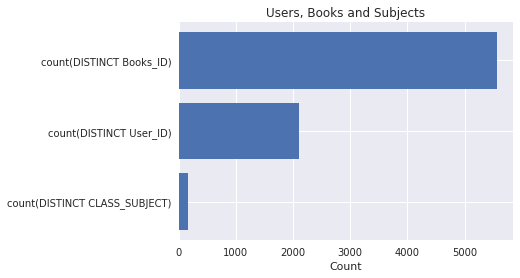

In [33]:
plt.figure()
plt.barh(range(df_merged_count_pd.shape[1]), df_merged_count_pd[["count(DISTINCT Books_ID)","count(DISTINCT User_ID)", "count(DISTINCT CLASS_SUBJECT)"][::-1]].values.flatten())
plt.xlabel("Count")
plt.title("Users, Books and Subjects")
plt.yticks(list(range(df_merged_count_pd.shape[1])), ["count(DISTINCT Books_ID)","count(DISTINCT User_ID)", "count(DISTINCT CLASS_SUBJECT)"][::-1])
plt.show()

# 3. Interactive EDA

In [34]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

## 3.1 User History

In [35]:
user_history_list = df_merged.select("User_ID").distinct().sort("USER_ID").toPandas().values.flatten().tolist()

#callback function
def user_history(user_ID = 'pzkzczrly', rows_to_show = 10):
    return df_merged.filter(df_merged["User_ID"] == user_ID).drop("ID", "SUBJECTS", "CLASS_SUBJECT").show(rows_to_show)

#UI
user_history_id_dropdown = widgets.Dropdown(
    options=user_history_list,
    value='AGmm',
    description='User: ',
    disabled=False,
)
user_history_rows_slider = widgets.IntSlider(min=1,max=50,step=1,value=5, description = "Rows: ")
user_history_ui = widgets.HBox([user_history_id_dropdown, user_history_rows_slider])

#output
user_history_out = widgets.interactive_output(user_history, {'user_ID': user_history_id_dropdown, 'rows_to_show': user_history_rows_slider})

In [36]:
display(user_history_ui, user_history_out)

Output()

## 3.2 Top Books by Classfication (Subject) 

In [37]:
subject_list = df_merged.select("CLASS_SUBJECT").distinct().sort("CLASS_SUBJECT").toPandas().values.flatten().tolist()

#callback function
def subject_top_books(subject = 'AC', books_to_show = 10):
    temp = df_merged.filter(df_merged["CLASS_SUBJECT"] == subject).select("CLASS_SUBJECT", "BOOKS_ID", "TITLE").groupBy("BOOKS_ID").agg({"CLASS_SUBJECT":"min","BOOKS_ID":"count", "TITLE":"min"}).select("min(CLASS_SUBJECT)", "BOOKS_ID", "min(TITLE)", "count(BOOKS_ID)").withColumnRenamed("min(CLASS_SUBJECT)","CLASS_SUBJECT").withColumnRenamed("min(TITLE)","TITLE").take(books_to_show)
    temp2 = spark.createDataFrame(temp)
    temp3 = temp2.toPandas()
    if temp3.shape[0]>1:
        plt.figure()
        temp4  = temp3[["BOOKS_ID", "count(BOOKS_ID)"]].sort_values("count(BOOKS_ID)")
        plt.barh(range(temp4.shape[0]), temp4["count(BOOKS_ID)"].values)
        plt.xlabel("Times Borrowed")
        plt.ylabel("Book ID")
        plt.title("Top Books in Subject -> {}".format(subject))
        plt.yticks(range(temp4.shape[0]), temp4["BOOKS_ID"].values)
    return temp2.sort("count(BOOKS_ID)", ascending=False).show()
#UI
subject_dropdown = widgets.Dropdown(
    options=subject_list,
    value="AC",
    description='Subject: ',
    disabled=False,
)
subject_books_slider = widgets.IntSlider(min=1,max=50,step=1,value=5, description = "Books: ")
subject_ui = widgets.HBox([subject_dropdown, subject_books_slider])

#output
subject_out = widgets.interactive_output(subject_top_books, {'subject': subject_dropdown, 'books_to_show': subject_books_slider})

In [38]:
display(subject_ui, subject_out)

Output()

# 4.  Collaborative Filtering

In [39]:
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating
from pyspark.sql.functions import lit, row_number

In [40]:
df_merged_CF = df_merged.withColumn("borrowed", lit(1.0))

In [41]:
df_merged_CF.show(5)

+---------+------------+------------+-----------------+--------------------+--------------------+-------------+--------+
|  User_ID|    Books_ID|          ID|            CLASS|               TITLE|            SUBJECTS|CLASS_SUBJECT|borrowed|
+---------+------------+------------+-----------------+--------------------+--------------------+-------------+--------+
|pzkzczrly|000004169001|000004169001|N 5300 .G6419/S26|Sanat?n �yk�s� = ...|Art--History
Sana...|            N|     1.0|
|kzlcpzfll|000004169001|000004169001|N 5300 .G6419/S26|Sanat?n �yk�s� = ...|Art--History
Sana...|            N|     1.0|
|mzplkmfll|000004169001|000004169001|N 5300 .G6419/S26|Sanat?n �yk�s� = ...|Art--History
Sana...|            N|     1.0|
|mzlmacrzl|000004169001|000004169001|N 5300 .G6419/S26|Sanat?n �yk�s� = ...|Art--History
Sana...|            N|     1.0|
|mzlmacrzl|000004169001|000004169001|N 5300 .G6419/S26|Sanat?n �yk�s� = ...|Art--History
Sana...|            N|     1.0|
+---------+------------+--------

In [42]:
user_id_mapping_dict = dict(zip([row["User_ID"] for row in df_merged_CF.select("User_ID").distinct().sort("User_ID").collect()],
                           range(1, df_merged_CF.select("User_ID").distinct().count()+1)))

In [43]:
book_id_mapping_dict = dict(zip([row["Books_ID"] for row in df_merged_CF.select("Books_ID").distinct().sort("Books_ID").collect()],
                           range(1, df_merged_CF.select("Books_ID").distinct().count()+1)))

In [44]:
ratings = df_merged_CF.rdd.map(lambda row: Rating(int(user_id_mapping_dict[row["User_ID"]]), int(book_id_mapping_dict[row["Books_ID"]]), float(row["borrowed"])))

# Build the recommendation model using Alternating Least Squares
rank = 30
numIterations = 10
model = ALS.trainImplicit(ratings, rank, numIterations)

# Evaluate the model on training data
testdata = ratings.map(lambda p: (p[0], p[1]))
predictions = model.predictAll(testdata).map(lambda r: ((r[0], r[1]), r[2]))
ratesAndPreds = ratings.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)


In [45]:
MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
print("Mean Squared Error = " + str(MSE))
MAE = ratesAndPreds.map(lambda r: (abs(r[1][0] - r[1][1]))).mean()
print("Mean Absolute Error = " + str(MAE))

Mean Squared Error = 10.404912077837066
Mean Absolute Error = 1.7476634164525018


In [46]:
rec_user_id_list = df_merged.select("User_ID").distinct().sort("USER_ID").toPandas().values.flatten().tolist()

#callback function
def dict_reverse_lookup(val, dict_):
    for key in dict_:
        if dict_[key] == val:
            return key
        
def generate_recommendations(user_ID = 'pzkzczrly', num_recommendations = 10):
    temp = model.recommendProducts(user_id_mapping_dict[user_ID], num_recommendations)
    temp = pd.DataFrame(temp)
    temp.columns = ["user", "book", "rating"]
    temp["user"] = temp["user"].apply(lambda user:dict_reverse_lookup(user, user_id_mapping_dict))
    temp["book"] = temp["book"].apply(lambda book:dict_reverse_lookup(book, book_id_mapping_dict))
    display(temp)

#UI
rec_user_id_dropdown = widgets.Dropdown(
    options=rec_user_id_list,
    value='AGmm',
    description='User: ',
    disabled=False,
)
rec_num_slider = widgets.IntSlider(min=1,max=50,step=1,value=5, description = "Recommendations: ")
recommendations_ui = widgets.HBox([rec_user_id_dropdown, rec_num_slider])

#output
recommendations_out = widgets.interactive_output(generate_recommendations, {'user_ID': rec_user_id_dropdown, 'num_recommendations': rec_num_slider})

In [47]:
display(recommendations_ui, recommendations_out)

Output()

In [26]:
dataset = df_users.join(df_books, df_users.Books_ID == df_books.ID)

# 5. Some insights

In [30]:
dataset = df_users.join(df_books, df_users.Books_ID == df_books.ID)
dataset.select('User_ID', 'TITLE', "SUBJECTS").show()

+---------+--------------------+--------------------+
|  User_ID|               TITLE|            SUBJECTS|
+---------+--------------------+--------------------+
|pzkzczrly|Sanat?n �yk�s� = ...|Art--History
Sana...|
|kzlcpzfll|Sanat?n �yk�s� = ...|Art--History
Sana...|
|mzplkmfll|Sanat?n �yk�s� = ...|Art--History
Sana...|
|mzlmacrzl|Sanat?n �yk�s� = ...|Art--History
Sana...|
|mzlmacrzl|Sanat?n �yk�s� = ...|Art--History
Sana...|
|      zzz|Mughal poetry : i...|Persian Poetry--M...|
|lzlkrmlyc|  Korku ruhu kemirir|German Literature...|
|kzfcpzzmk|  Korku ruhu kemirir|German Literature...|
|mzplkzzrk|  Korku ruhu kemirir|German Literature...|
|mzplkzzrk|  Korku ruhu kemirir|German Literature...|
|mzzllzfkz|  Korku ruhu kemirir|German Literature...|
|mzaccmrkz|Equations of eter...|Matter--Mathemati...|
|     zzff|The voyage of the...|Natural History
G...|
|mzkczczam|The holographic u...|Holography--Philo...|
|mzacamalc|       Into the wild|Mccandless, Chris...|
|mzaypcyyf|     Anayasa notl

In [31]:
columns = [dataset.schema.names[0], dataset.schema.names[4], dataset.schema.names[5]]
values = []
for i in dataset.collect():
    subjects = str(i.SUBJECTS).split('--')
    for subject in subjects:
        row_ = (i.User_ID, i.TITLE, subject)
        values.append(row_)
df_2 = spark.createDataFrame(values, columns)
df_2.show()

+---------+--------------------+--------------------+
|  User_ID|               TITLE|            SUBJECTS|
+---------+--------------------+--------------------+
|pzkzczrly|Sanat?n �yk�s� = ...|                 Art|
|pzkzczrly|Sanat?n �yk�s� = ...|       History
Sanat|
|pzkzczrly|Sanat?n �yk�s� = ...|               Tarih|
|kzlcpzfll|Sanat?n �yk�s� = ...|                 Art|
|kzlcpzfll|Sanat?n �yk�s� = ...|       History
Sanat|
|kzlcpzfll|Sanat?n �yk�s� = ...|               Tarih|
|mzplkmfll|Sanat?n �yk�s� = ...|                 Art|
|mzplkmfll|Sanat?n �yk�s� = ...|       History
Sanat|
|mzplkmfll|Sanat?n �yk�s� = ...|               Tarih|
|mzlmacrzl|Sanat?n �yk�s� = ...|                 Art|
|mzlmacrzl|Sanat?n �yk�s� = ...|       History
Sanat|
|mzlmacrzl|Sanat?n �yk�s� = ...|               Tarih|
|mzlmacrzl|Sanat?n �yk�s� = ...|                 Art|
|mzlmacrzl|Sanat?n �yk�s� = ...|       History
Sanat|
|mzlmacrzl|Sanat?n �yk�s� = ...|               Tarih|
|      zzz|Mughal poetry : i

In [32]:
# I sorted the dataframe based on subject. It came out that number books related to Turkey is the highest.
print ('The most read subjects are:')
df_2.groupBy('SUBJECTS').agg(count('SUBJECTS').alias('num')).sort('num', ascending=False).show()

The most read subjects are:
+--------------------+----+
|            SUBJECTS| num|
+--------------------+----+
|               Tarih|2588|
|             T�rkiye|2051|
|             History|2035|
|              Turkey|1433|
|    English Language|1425|
|Textbooks for For...|1230|
|Ders Kitaplar?, Y...|1174|
|               Roman| 880|
|Learning Material...| 873|
|�?renim Materyalleri| 873|
|  Turkish Literature| 591|
|  Siyaset ve Y�netim| 531|
|Politics and Gove...| 484|
|          20. Y�zy?l| 391|
|       D?? ?li?kiler| 360|
|   Foreign Relations| 347|
|Fiction
T�rk Edeb...| 330|
|  Birle?ik Devletler| 330|
|       United States| 280|
|Problems, Exercis...| 265|
+--------------------+----+
only showing top 20 rows



# 6. Recommending books

In [27]:
# main_dict accomodates all users, with the books they read and the ratings. Since we don't have ratings, I consider
# the number a user borrowed a book as rating. So most of the ratings are 1. You can see that qendrim and almir have 3 common
# books. The forth book read by almir is recommended for qendrim to read.
main_dict = {}
for i in dataset.collect():
    user_id = i.User_ID
    book_name = i.TITLE
    if user_id in main_dict:
        if book_name in main_dict[user_id]:
            main_dict[user_id][book_name] += 1
        else:
            main_dict[user_id][book_name] = 1
    else:
        main_dict[user_id] = {}
        main_dict[user_id][book_name] = 1

In [28]:
from recommendations import *

# getRecommendations compares the book ratings by each user, and calcute the similarity in taste between the users, according
# to which it recommends books. sim_distance similarity measure is used in this case
rec = getRecommendations(main_dict, "pzkzczrly", sim_distance)[:6]
print ('Books recommended for pzkzczrly:')
for i in rec:
    print (i[1])

Books recommended for pzkzczrly:
Student handbook to economics
K�rtler ne istiyor? : K�rdistan'da etnik kimlik, dindarl?k, s?n?f ve se�imler
�z�nt�den kurtulman?n yollar? = el-hile li-def'i'l-ahzan
�zne ve iktidar = Dits et �crits
�yle miymi?
�lmeye yatmak


# 6. Final Comments

The insights we expect to draw forth from the project are manifold and are likely to inform both the users as well as the library personnel in their various decisions.

By drawing on collective user behavior in the past, the recommender system we implemented can definitely help library users by suggesting books similar to the ones they have requested for. Without such a system, the process of finding similar books would rely on actually visiting the library and leafing through the books on the same shelf. Thus this can help in reducing the searching cost (time consumption) from the library users and increase the effectivity. 




![title](tools.png)